In [0]:
#Import libraries needed
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
dataset = pd.read_csv('/content/housing.csv')
dataset = dataset.dropna()
print("Here are the first ten rows of the dataset:")
#To print the first ten rows of dataset
dataset.head(10)

Here are the first ten rows of the dataset:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f191fb18e80>,
      dtype=object)

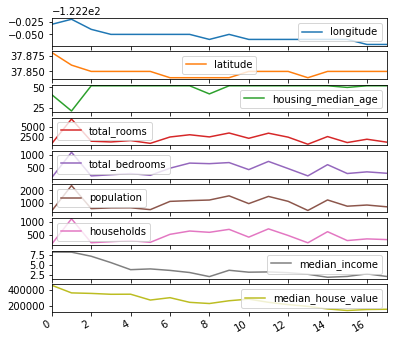

In [6]:
#To visualize the dataset using plot() function
dataset.head(18).plot(kind='line',subplots=True,figsize=(6,6))

In [0]:
#predict the median_house_value
Y = dataset['median_house_value']

#Input
X = dataset.loc[:,'longitude':'median_income']

In [0]:
#Splitting the test and train set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=2003)

x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()

x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
#import layers for 1D cnn

import torch

from torch.nn import Conv1d

from torch.nn import MaxPool1d

from torch.nn import AvgPool1d

from torch.nn import Flatten

from torch.nn import Linear

from torch.nn.functional import relu

from torch.utils.data import DataLoader, TensorDataset

In [0]:
class CnnRegressor(torch.nn.Module):
  #define init method
  def __init__(self, batch_size, inputs, outputs):
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    self.input_layer = Conv1d(inputs, batch_size,1)
    self.avg_pooling_layer = AvgPool1d(1)
    self.conv_layer = Conv1d(batch_size, 128, 1)
    self.max_pooling_layer = MaxPool1d(1)
    self.flatten_layer = Flatten()
    self.output_layer = Linear(128, outputs)

  def feed(self, input):
    input = input.reshape((self.batch_size, self.inputs, 1))
    output = relu(self.input_layer(input))
    output = self.avg_pooling_layer(output)
    output = relu(self.conv_layer(output))
    output = self.max_pooling_layer(output)
    output = self.flatten_layer(output)
    output = self.output_layer(output)
    return output

In [89]:
#import optimisers, loss and R^2 score 

from torch.optim import SGD

from torch.optim import Adamax

from torch.nn import L1Loss

!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [18]:
batch_size = 64
model = CnnRegressor(batch_size, X.shape[1], 1)
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (avg_pooling_layer): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (flatten_layer): Flatten()
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [0]:
#define method to return average L1 Loss and R^2 score
def model_loss(model, dataset, train = False, optimizer = None):
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0
  for input, output in iter(dataset):
    predictions = model.feed(input)
    loss = performance(predictions, output)
    score_metric.update([predictions, output])
    score = score_metric.compute()
    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    avg_loss += loss.item()
    avg_score += score
    count += 1
  return avg_loss / count, avg_score / count

In [95]:
epochs = 100

#optimizer = SGD(model.parameters(), lr=1e-5)
optimizer = Adamax(model.parameters())
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

for epoch in range(epochs):
  avg_loss, avg_r2_score = model_loss(model, loader, train=True, optimizer=optimizer)

  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))

Epoch 1:
	Loss = 44146.61869394619
	R^2 Score = 0.685141553350368
Epoch 2:
	Loss = 44086.62281915639
	R^2 Score = 0.7129523151396525
Epoch 3:
	Loss = 44104.60663361827
	R^2 Score = 0.6887780254808114
Epoch 4:
	Loss = 43996.7259143778
	R^2 Score = 0.7108989675035442
Epoch 5:
	Loss = 44047.14994394619
	R^2 Score = 0.7002688222720079
Epoch 6:
	Loss = 44073.08635790359
	R^2 Score = 0.6980526830574941
Epoch 7:
	Loss = 44047.15899138173
	R^2 Score = 0.7090836889319051
Epoch 8:
	Loss = 44052.40530409193
	R^2 Score = 0.7022916012422359
Epoch 9:
	Loss = 43987.81899873879
	R^2 Score = 0.7070116525178104
Epoch 10:
	Loss = 44040.985075672645
	R^2 Score = 0.7105062495215623
Epoch 11:
	Loss = 44054.58689216648
	R^2 Score = 0.7065177208555519
Epoch 12:
	Loss = 43999.75641115471
	R^2 Score = 0.7122515885946297
Epoch 13:
	Loss = 43978.48475161155
	R^2 Score = 0.7079040768528715
Epoch 14:
	Loss = 44000.54824131166
	R^2 Score = 0.7047013334866833
Epoch 15:
	Loss = 43993.72733323991
	R^2 Score = 0.6992960

In [97]:
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle = True, drop_last=True)

avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's L1 loss is: " + str(avg_loss))
print("The model's R^2 score is: " + str(avg_r2_score))

The model's L1 loss is: 46292.49806743421
The model's R^2 score is: 0.672736333137679
